In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import load

In [27]:
# 1. Cargar el dataset de validación (no visto durante el entrenamiento)
df_val = pd.read_csv("../data/feature_engineering_final.csv")  # Cargamos dataset de validación (%20)

In [28]:
df_val

,year,kms,power,price,make_Abarth,make_Alfa Romeo,make_Alpine,make_Aston Martin,make_Audi,make_BMW,...,segmento_A,segmento_B,segmento_C,segmento_D,segmento_E,segmento_F,segmento_J,segmento_M,segmento_S,segmento_otros
0,2016,155938.0,120.0,11100,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,2007,202000.0,143.0,5900,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,2018,73500.0,190.0,27900,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,2010,185000.0,177.0,9999,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,2013,138399.0,110.0,9990,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,2020,105102.0,150.0,25990,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2233,2022,4797.0,141.0,26900,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2234,2016,135779.0,135.0,12199,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2235,2005,194600.0,98.0,2900,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [29]:
df_val.describe()

,year,kms,power,price
count,2237.000000,2237.000000,2237.000000,2237.000000
mean,2015.248547,100851.754582,156.277157,21164.386679
std,5.255622,68198.494624,98.637185,23245.328601
min,1992.000000,200.000000,11.000000,1000.000000
25%,2013.000000,47270.000000,102.000000,10699.000000
50%,2017.000000,89000.000000,130.000000,15990.000000
75%,2019.000000,140630.000000,165.000000,24000.000000
max,2023.000000,475000.000000,816.000000,389900.000000


In [30]:


# Aplicar Transformación logarítmica al target (igual que en el entrenamiento)
cols_to_transform = ['price']
df_val[cols_to_transform] = df_val[cols_to_transform].apply(np.log1p)

# 2. Separar X e y para el conjunto de validación
X_val = df_val.drop(columns="price")
y_log_val = df_val["price"]

# 3. Cargar los modelos ya entrenados
modelo_clasificador = load("../model/Modelo2_clasificacion_rf.pkl")
modelo_regresion_barato = load("../model/Modelo3_regresion_cat_logY_split.pkl")
modelo_regresion_caro = load("../model/Modelo4_regresion_rf_logY_split.pkl")

def predecir_y_evaluar(X, y_log, clasificador, modelo_barato, modelo_caro):
    # Clasificar en barato/caro
    es_caro = clasificador.predict(X)

    # Separar subconjuntos
    X_barato = X[es_caro == 0]
    X_caro = X[es_caro == 1]

    # Predecir con los modelos que devuelven log(price)
    y_pred_barato_log = modelo_barato.predict(X_barato)
    y_pred_caro_log = modelo_caro.predict(X_caro)

    # Volver a la escala original
    y_pred_barato = np.expm1(y_pred_barato_log)
    y_pred_caro = np.expm1(y_pred_caro_log)

    # Unir predicciones
    y_pred = np.zeros(len(X))
    y_pred[es_caro == 0] = y_pred_barato
    y_pred[es_caro == 1] = y_pred_caro

    # Convertir y real a escala original también
    y = np.expm1(y_log)

    # Calcular métricas
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)

    return mae, rmse, r2

# Evaluar en el conjunto de validación final
mae_val, rmse_val, r2_val = predecir_y_evaluar(
    X_val, y_log_val, modelo_clasificador, modelo_regresion_barato, modelo_regresion_caro
)

# Mostrar resultados
print("=== Métricas en el conjunto de VALIDACIÓN FINAL ===")
print(f"MAE: {mae_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"R²: {r2_val:.3f}")

=== Métricas en el conjunto de VALIDACIÓN FINAL ===
MAE: 2691.92
RMSE: 6565.08
R²: 0.920


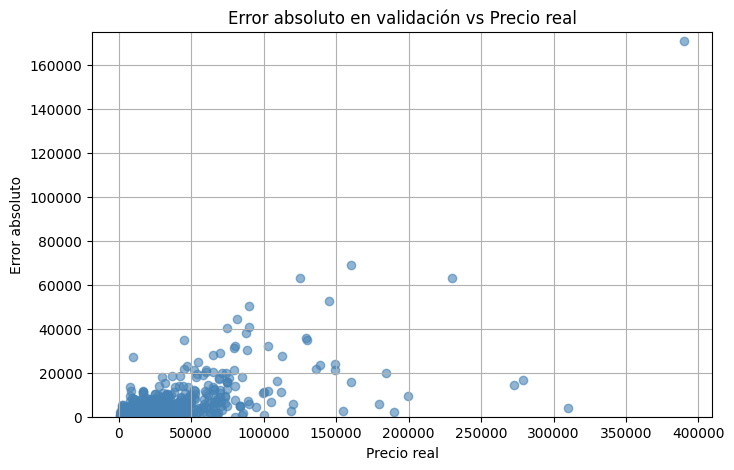

In [31]:
import matplotlib.pyplot as plt

# Repetimos lógica de predicción para obtener predicciones individuales en validación

# Clasificación
es_caro_val = modelo_clasificador.predict(X_val)
X_barato_val = X_val[es_caro_val == 0]
X_caro_val = X_val[es_caro_val == 1]

# Predicción en escala log
y_pred_barato_log = modelo_regresion_barato.predict(X_barato_val)
y_pred_caro_log = modelo_regresion_caro.predict(X_caro_val)

# Volver a la escala original
y_pred_barato = np.expm1(y_pred_barato_log)
y_pred_caro = np.expm1(y_pred_caro_log)

# Unir predicciones
y_pred_val = np.empty(len(X_val))
y_pred_val[es_caro_val == 0] = y_pred_barato
y_pred_val[es_caro_val == 1] = y_pred_caro

# Convertir y_val a escala original también
y_val_original = np.expm1(y_log_val)

# Calcular errores absolutos
errores_abs_val = np.abs(y_val_original.values - y_pred_val)

# Gráfico
plt.figure(figsize=(8, 5))
plt.scatter(y_val_original, errores_abs_val, alpha=0.6, c='steelblue')
plt.xlabel('Precio real')
plt.ylabel('Error absoluto')
plt.title('Error absoluto en validación vs Precio real')
plt.ylim(0, 175000)  # Ajusta si es necesario según tu dataset
plt.grid(True)
plt.show()